In [36]:
# import the required libraries
import numpy as np
import time
import random
import cPickle
import codecs
import collections
import os
import math
import json
import tensorflow as tf
from six.moves import xrange
import pickle
from scipy import stats

# libraries required for visualisation:
from IPython.display import SVG, display
import svgwrite # conda install -c omnia svgwrite=1.1.6
import PIL
from PIL import Image
import matplotlib.pyplot as plt
from svgpathtools import svg2paths, wsvg

# set numpy output to something sensible
np.set_printoptions(precision=8, edgeitems=6, linewidth=200, suppress=True)

from magenta.models.sketch_rnn.sketch_rnn_train import *
from magenta.models.sketch_rnn.model import *
from magenta.models.sketch_rnn.utils import *
from magenta.models.sketch_rnn.rnn import *

In [45]:
tf.logging.info("TensorFlow Version: %s", tf.__version__)
# little function that displays vector images and saves them to .svg
def draw_strokes(data, factor=0.2, svg_filename = 'home/calpeyser/sketch/svg/sample.svg'):
  tf.gfile.MakeDirs(os.path.dirname(svg_filename))
  min_x, max_x, min_y, max_y = get_bounds(data, factor)
  dims = (50 + max_x - min_x, 50 + max_y - min_y)
  dwg = svgwrite.Drawing(svg_filename, size=dims)
  dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
  lift_pen = 1
  abs_x = 25 - min_x 
  abs_y = 25 - min_y
  p = "M%s,%s " % (abs_x, abs_y)
  command = "m"
  for i in xrange(len(data)):
    if (lift_pen == 1):
      command = "m"
    elif (command != "l"):
      command = "l"
    else:
      command = ""
    x = float(data[i,0])/factor
    y = float(data[i,1])/factor
    lift_pen = data[i, 2]
    p += command+str(x)+","+str(y)+" "
  the_color = "black"
  stroke_width = 1
  dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
  dwg.save()
  display(SVG(dwg.tostring()))

# generate a 2D grid of many vector drawings
def make_grid_svg(s_list, grid_space=10.0, grid_space_x=16.0):
  def get_start_and_end(x):
    x = np.array(x)
    x = x[:, 0:2]
    x_start = x[0]
    x_end = x.sum(axis=0)
    x = x.cumsum(axis=0)
    x_max = x.max(axis=0)
    x_min = x.min(axis=0)
    center_loc = (x_max+x_min)*0.5
    return x_start-center_loc, x_end
  x_pos = 0.0
  y_pos = 0.0
  result = [[x_pos, y_pos, 1]]
  for sample in s_list:
    s = sample[0]
    grid_loc = sample[1]
    grid_y = grid_loc[0]*grid_space+grid_space*0.5
    grid_x = grid_loc[1]*grid_space_x+grid_space_x*0.5
    start_loc, delta_pos = get_start_and_end(s)

    loc_x = start_loc[0]
    loc_y = start_loc[1]
    new_x_pos = grid_x+loc_x
    new_y_pos = grid_y+loc_y
    result.append([new_x_pos-x_pos, new_y_pos-y_pos, 0])

    result += s.tolist()
    result[-1][2] = 1
    x_pos = new_x_pos+delta_pos[0]
    y_pos = new_y_pos+delta_pos[1]
  return np.array(result)

sheep_model_dir = "/home/calpeyser/sketch/models/aaron_sheep/lstm"
sheep_data_dir = "http://github.com/hardmaru/sketch-rnn-datasets/raw/master/aaron_sheep/"
owl_model_dir = "/home/calpeyser/sketch/models/owl/lstm"
owl_data_dir = "/home/calpeyser/sketch/data/owl/"
flam_model_dir = "/home/calpeyser/sketch/models/flamingo/lstm_uncond"
flam_data_dir = "/home/calpeyser/sketch/data/flamingo/"



INFO:tensorflow:TensorFlow Version: 1.2.1


In [3]:
[sheep_train_set, sheep_valid_set, sheep_test_set, sheep_hps_model, sheep_eval_hps_model, sheep_sample_hps_model] = load_env(sheep_data_dir, sheep_model_dir)
sheep_eval_model = Model(sheep_eval_hps_model, reuse=False)
sheep_sample_model = Model(sheep_sample_hps_model, reuse=True)

[owl_train_set, owl_valid_set, owl_test_set, owl_hps_model, owl_eval_hps_model, owl_sample_hps_model] = load_env(owl_data_dir, owl_model_dir)
owl_eval_model = Model(owl_eval_hps_model, reuse=True)
owl_sample_model = Model(owl_sample_hps_model, reuse=True)


#[flam_train_set, flam_valid_set, flam_test_set, flam_hps_model, flam_eval_hps_model, flam_sample_hps_model] = load_env(flam_data_dir, flam_model_dir)
#flam_eval_model = Model(flam_eval_hps_model, reuse=True)
#flam_sample_model = Model(flam_sample_hps_model, reuse=True)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

INFO:tensorflow:Downloading http://github.com/hardmaru/sketch-rnn-datasets/raw/master/aaron_sheep/aaron_sheep.npz
INFO:tensorflow:Loaded 7400/300/300 from aaron_sheep.npz
INFO:tensorflow:Dataset combined: 8000 (7400/300/300), avg len 125
INFO:tensorflow:model_params.max_seq_len 250.
total images <= max_seq_len is 7400
total images <= max_seq_len is 300
total images <= max_seq_len is 300
INFO:tensorflow:normalizing_scale_factor 18.5198.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Loaded 70000/2500/2500 from extended_owl.npz
INFO:tensorflow:Dataset combined: 75000 (70000/2500/2500), avg len 85
INFO:tensorflow:model_params.max_seq_len 148.
total images <= max_seq_len is 70000
total images <= max_seq_len is

In [4]:
def encode(eval_model, input_strokes, max_len=129):
  strokes = to_big_strokes(input_strokes, max_len=max_len).tolist()
  strokes.insert(0, [0, 0, 1, 0, 0])
  seq_len = [len(input_strokes)]
  #draw_strokes(to_normal_strokes(np.array(strokes)))
  return sess.run(eval_model.batch_z, feed_dict={eval_model.input_data: [strokes], eval_model.sequence_lengths: seq_len})[0]
def decode(eval_model, sample_model, z_input=None, draw_mode=True, temperature=0.1, factor=0.2):
  z = None
  if z_input is not None:
    z = [z_input]
  sample_strokes, m = sample(sess, sample_model, seq_len=eval_model.hps.max_seq_len, temperature=temperature, z=z)
  strokes = to_normal_strokes(sample_strokes)
  return strokes

In [ ]:
load_checkpoint(sess, cat_model_dir)
cat = cat_test_set.random_sample()
print(cat.shape)
encoding = encode(cat_eval_model, cat)
decoding = decode(cat_eval_model, cat_sample_model, encoding)

draw_strokes(cat)
print(encoding)
draw_strokes(decoding)
 

In [8]:
# Generate dataset
for i in range(1000):
    draw_strokes(owl_train_set.strokes[i], svg_filename="/home/calpeyser/sketch/sketches/owl/" + str(i) + ".svg")
    if (i % 100 == 0):
        print(i)

0
100
200
300
400
500
600
700
800
900


In [42]:
# Sort samples by size
def svg_len(paths):
    out = 0
    for line in paths:
        out += line.length()
    return out

def sort_category(category):
    sorted_svgs = []
    for i in range(1000):
        paths, attributes = svg2paths('/home/calpeyser/sketch/sketches/' + category + '/' + str(i) + '.svg')
        sorted_svgs.append((i, svg_len(paths)))
    sorted_svgs = sorted(sorted_svgs, key=lambda tup:tup[1])
    return [sorted_svgs[i][0] for i in range(1000)]

sheep_by_size_ind = sort_category("sheep")
owl_by_size_ind = sort_category("owl")

# load sheep model, map sketches onto embeddings
load_checkpoint(sess, sheep_model_dir)
sheep_by_size = [encode(sheep_eval_model, sheep_train_set.strokes[i], max_len=250) for i in sheep_by_size_ind]


# load owl model, map sketches onto embeddings
load_checkpoint(sess, owl_model_dir)
owl_by_size = [encode(owl_eval_model, owl_train_set.strokes[i], max_len=148) for i in owl_by_size_ind]



INFO:tensorflow:Loading model /home/calpeyser/sketch/models/aaron_sheep/lstm/vector.
INFO:tensorflow:Restoring parameters from /home/calpeyser/sketch/models/aaron_sheep/lstm/vector
INFO:tensorflow:Loading model /home/calpeyser/sketch/models/owl/lstm/vector.
INFO:tensorflow:Restoring parameters from /home/calpeyser/sketch/models/owl/lstm/vector


In [43]:
# Save to pkl
PKL_path = '/home/calpeyser/sketch/labels/'
f = open(PKL_path + 'sheep', 'wb')
pickle.dump(sheep_by_size, f)
f.close()

f = open(PKL_path + 'sheep_ind', 'wb')
pickle.dump(sheep_by_size_ind, f)
f.close()

f = open(PKL_path + 'owl', 'wb')
pickle.dump(owl_by_size, f)
f.close()

f = open(PKL_path + 'owl_ind', 'wb')
pickle.dump(owl_by_size_ind, f)
f.close()

In [5]:
# Load from pkl
PKL_path = '/home/calpeyser/sketch/labels/'
sheep_by_size = pickle.load(open('/home/calpeyser/sketch/labels/sheep', 'rb'))
sheep_by_size_ind = pickle.load(open('/home/calpeyser/sketch/labels/sheep_ind', 'rb')) 
owl_by_size = pickle.load(open('/home/calpeyser/sketch/labels/owl', 'rb'))
owl_by_size_ind = pickle.load(open('/home/calpeyser/sketch/labels/owl_ind', 'rb'))

INFO:tensorflow:Loading model /home/calpeyser/sketch/models/aaron_sheep/lstm/vector.
INFO:tensorflow:Restoring parameters from /home/calpeyser/sketch/models/aaron_sheep/lstm/vector
INFO:tensorflow:Loading model /home/calpeyser/sketch/models/owl/lstm/vector.
INFO:tensorflow:Restoring parameters from /home/calpeyser/sketch/models/owl/lstm/vector


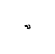

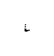

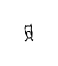

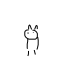

---------


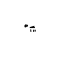

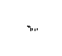

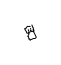

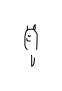

---------


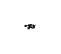

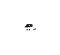

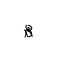

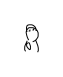

---------


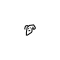

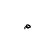

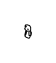

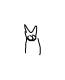

---------


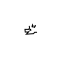

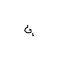

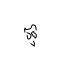

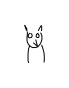

---------


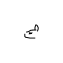

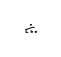

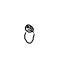

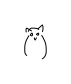

---------


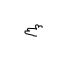

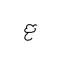

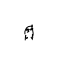

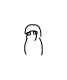

---------


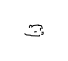

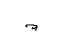

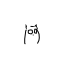

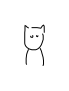

---------


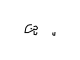

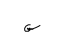

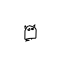

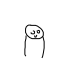

---------


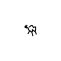

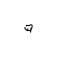

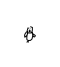

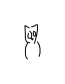

---------


In [48]:
# Sanity check encodings
sheep = []
real_sheep = []
owl = []
real_owl = []

# Decode sheep
load_checkpoint(sess, sheep_model_dir)
for i, s in enumerate(sheep_by_size[:10]):
    decoding = decode(sheep_eval_model, sheep_sample_model, s)
    sheep.append(decoding)
    real_sheep.append(sheep_train_set.strokes[sheep_by_size_ind[i]])
    
# Decode owls
load_checkpoint(sess, owl_model_dir)
for i, o in enumerate(owl_by_size[:10]):
    decoding = decode(owl_eval_model, owl_sample_model, o)
    owl.append(decoding)
    real_owl.append(owl_train_set.strokes[owl_by_size_ind[i]])
    
for d, s, r, o in zip(real_sheep, sheep, real_owl, owl):
    draw_strokes(d)
    draw_strokes(s)
    draw_strokes(r)
    draw_strokes(o)
    print("---------")


In [25]:
# Compute average variance across data
sheep_variences = np.var(np.array(sheep_by_size), axis=0)
owl_variences = np.var(np.array(owl_by_size), axis=0)
variances = np.mean([sheep_variences, owl_variences], axis=0)


In [27]:
# Train a linear model on the sketch labels
STARTER_LEARNING_RATE = 0.04
EPOCH_COUNT = 15000

linear_graph = tf.Graph()
with linear_graph.as_default():
    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.train.exponential_decay(STARTER_LEARNING_RATE, global_step, 10000, 0.96, staircase=True)

    # Constants: MSE weights
    VAR_x_to_y = tf.constant(variances)

    # TF graph input
    X = tf.placeholder("float64")
    Y = tf.placeholder("float64")

    # TF weights
    #W = tf.Variable(np.random.rand(128, 128), name = "linear_model_weight")
    W_x_to_y = tf.Variable(np.random.rand(128), name = "linear_model_weight_x_to_y")
    b_x_to_y = tf.Variable(np.random.rand(128), name = "linear_model_bias_x_to_y")
    W_y_to_x = tf.Variable(np.random.rand(128), name = "linear_model_weight_y_to_x")
    b_y_to_x = tf.Variable(np.random.rand(128), name = "linear_model_weight_y_to_x")

    # Linear prediction
    #prediction = tf.squeeze(tf.add(tf.matmul(tf.expand_dims(X, 0), W), b))
    prediction_x_to_y = tf.add(tf.multiply(X, W_x_to_y), b_x_to_y)
    prediction_y_to_x = tf.add(tf.multiply(Y, W_y_to_x), b_y_to_x)
    
    
    #cost = tf.reduce_sum(tf.pow(prediction - Y, 2)/(2*len(labels)))
    cost = tf.losses.mean_squared_error(Y, prediction_x_to_y, weights=VAR_x_to_y) + tf.losses.mean_squared_error(X, prediction_y_to_x, weights=VAR_x_to_y)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost, global_step=global_step)

    init = tf.variables_initializer([W_x_to_y, W_y_to_x, b_x_to_y, b_y_to_x, global_step])

linear_model_sess = tf.Session(graph=linear_graph)
linear_model_sess.run(init)
costs = []
for epoch in range(EPOCH_COUNT):
    indexes = range(1000)
    random.shuffle(indexes)
    for i in indexes:
        sheep = sheep_by_size[i]
        owl = owl_by_size[i]
    
    _, cost_ = linear_model_sess.run([optimizer, cost], feed_dict={X: sheep, Y: owl})
    costs.append(cost_)
    
    if (epoch % 1000) == 0:
        cost_computed = sum(costs)/len(costs)
        costs = []
        print("Epoch: %s, Cost: %s " % (epoch, cost_computed))



Epoch: 0, Cost: 3.1570823192596436 
Epoch: 1000, Cost: 2.4624000724554063 
Epoch: 2000, Cost: 1.9445832495689392 
Epoch: 3000, Cost: 1.7798336666822434 
Epoch: 4000, Cost: 1.7191688611507416 
Epoch: 5000, Cost: 1.698323509812355 
Epoch: 6000, Cost: 1.6938283579349518 
Epoch: 7000, Cost: 1.6872623255252839 
Epoch: 8000, Cost: 1.6913840568065643 
Epoch: 9000, Cost: 1.6729024924039841 
Epoch: 10000, Cost: 1.6879310840368271 
Epoch: 11000, Cost: 1.6778217817544938 
Epoch: 12000, Cost: 1.6973604875802994 
Epoch: 13000, Cost: 1.697398478269577 
Epoch: 14000, Cost: 1.6910751707553864 


In [28]:
# Lets do some predictions
def svg_len(paths):
    out = 0
    for line in paths:
        out += line.length()
    return out

def predict_for_indexes(indexes):
    load_checkpoint(sess, owl_model_dir)
    owls = [owl_train_set.strokes[i] for i in indexes]
    encodings = [encode(owl_eval_model, owl, max_len=148) for owl in owls]
    predictions = [linear_model_sess.run(prediction_y_to_x, feed_dict = {Y: encoding}) for encoding in encodings]
    load_checkpoint(sess, sheep_model_dir)
    decodings = [decode(sheep_eval_model, sheep_sample_model, prediction) for prediction in predictions]
    
    res = []
    for owl, sheep in zip(owls, decodings):   
        draw_strokes(owl, svg_filename='/home/calpeyser/sketch/sketches/in.svg')
        draw_strokes(sheep, svg_filename = '/home/calpeyser/sketch/sketches/out.svg')      
        in_paths, _ = svg2paths('/home/calpeyser/sketch/sketches/in.svg')
        out_paths, _ = svg2paths('/home/calpeyser/sketch/sketches/out.svg')
        in_length = svg_len(in_paths)
        out_length = svg_len(out_paths)
        res.append((in_length, out_length))
    return res
    
lens_for_owl_transforms = predict_for_indexes(range(1000))


INFO:tensorflow:Loading model /home/calpeyser/sketch/models/owl/lstm/vector.
INFO:tensorflow:Restoring parameters from /home/calpeyser/sketch/models/owl/lstm/vector
INFO:tensorflow:Loading model /home/calpeyser/sketch/models/aaron_sheep/lstm/vector.
INFO:tensorflow:Restoring parameters from /home/calpeyser/sketch/models/aaron_sheep/lstm/vector


In [29]:
PKL_path = '/home/calpeyser/sketch/labels/lens_for_owl_transforms'
f = open(PKL_path, 'wb')
pickle.dump(lens_for_owl_transforms, f)

In [40]:
X = [a[0] for a in lens_for_owl_transforms]
Y = [a[1] for a in lens_for_owl_transforms]

slope, intercept, r_value, p_value, std_err = stats.linregress(X,Y)
print(slope)
print(intercept)
print(r_value ** 2)

0.024539923695106703
151.16593752309535
0.006381755772784301
